In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms, utils, models, datasets
from torch.utils.data import Dataset, DataLoader

In [4]:
from synthetic_utils import *

In [5]:
from trainer_dataloader import *
from networks import *
from losses import *

In [6]:
input_size = 96
batch_size = 128
num_workers = 4
num_epochs = 20

In [7]:
cuda = False
pin_memory = False
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    cuda = True
    cudnn.benchmark = True
    pin_memory = True
else:
    device = torch.device("cpu")

print('Device set: {}'.format(device))

Device set: cuda


In [8]:
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((input_size, input_size)),
#             transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'val': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
}

In [9]:
# DATA_PATH = '/home/s1791387/diss/gen_shapes/'
DATA_PATH = '/home/var/synthetic_data/gen_shapes/'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'valid')
TEST_PATH = os.path.join(DATA_PATH, 'test')

In [10]:
train_df = datasets.ImageFolder(root=TRAIN_PATH, transform=data_transforms['train'])
val_df = datasets.ImageFolder(root=VAL_PATH, transform=data_transforms['val'])
test_df = datasets.ImageFolder(root=TEST_PATH, transform=data_transforms['val'])

In [11]:
train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_df, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_df, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

## Train only encoder first


In [12]:
encoder = LeNet()
classifier = ClassNet()

In [13]:
encoder.to(device)
classifier.to(device)

ClassNet(
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=1, bias=True)
  (out_acc): Sigmoid()
)

In [14]:
criterion = nn.BCELoss()
opt_cls = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
opt_enc = optim.Adam(encoder.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_cls = lr_scheduler.StepLR(optimizer=opt_cls, gamma=0.99, step_size=1)
scheduler_enc = lr_scheduler.StepLR(optimizer=opt_enc, gamma=0.99, step_size=1)

In [15]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, 20):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_cls.step()
        scheduler_enc.step()
        # train
        train_loss, train_acc = train_encoder_classifier_epoch(train_loader, encoder,
                                classifier, opt_enc,
                                opt_cls, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_encoder_classifier_epoch(val_loader, encoder, classifier,
                                 criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 2.251 (2.251)	Loss 0.6833 (0.6833)	Accuracy 0.5703 (0.5703)
Batch: [10/40]	Time 0.067 (0.423)	Loss 0.6127 (0.6410)	Accuracy 0.6953 (0.6236)
Batch: [20/40]	Time 0.808 (0.373)	Loss 0.5454 (0.6126)	Accuracy 0.7422 (0.6548)
Batch: [30/40]	Time 0.064 (0.345)	Loss 0.5794 (0.5918)	Accuracy 0.6953 (0.6741)
----------


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test: [0/4]	Time 1.478 (1.478)	Loss 0.5678 (0.5678)	Accuracy 0.7188 (0.7188)
Avg validation loss: 0.491123708486557 	 Accuracy: 0.758
--------------------
Epoch 0/20	Time 15.155 sec (15.155 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 1.825 (1.825)	Loss 0.4495 (0.4495)	Accuracy 0.8047 (0.8047)
Batch: [10/40]	Time 0.286 (0.439)	Loss 0.5036 (0.4649)	Accuracy 0.7578 (0.7741)
Batch: [20/40]	Time 0.470 (0.372)	Loss 0.4169 (0.4631)	Accuracy 0.7891 (0.7742)
Batch: [30/40]	Time 0.128 (0.360)	Loss 0.3743 (0.4508)	Accuracy 0.8125 (0.7810)
----------
Test: [0/4]	Time 1.673 (1.673)	Loss 0.2709 (0.2709)	Accuracy 0.9297 (0.9297)
Avg validation loss: 0.3936647019386291 	 Accuracy: 0.818
--------------------
Epoch 1/20	Time 15.460 sec (15.308 sec)
--------------------
Epoch: 2/20
Batch: [0/40]	Time 1.663 (1.663)	Loss 0.3725 (0.3725)	Accuracy 0.8359 (0.8359)
Batch: [10/40]	Time 0.172 (0.417)	Loss 0.3591 (0.3748)	Accuracy 0.8281 (0.8317)
Batch: [20/40]	Time 0.864 (0.369)	Loss 0.4519 (0.3654)	Accuracy 0.7812 (0.8363)
Batch: [30/40]	Time 0.445 (0.351)	Loss 0.3193 (0.3548)	Accuracy 0.8594 (0.8420)
----------
Test: [0/4]	Time 1.671 (1.671)	Loss 0.2869 (0.2869)	Accuracy 0.9062 (0.9062)
Avg validation loss: 0.29463199687

In [16]:
validate_encoder_classifier_epoch(test_loader, encoder, classifier,
                                 criterion, device)

Test: [0/4]	Time 1.584 (1.584)	Loss 0.0523 (0.0523)	Accuracy 0.9766 (0.9766)


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


(0.1062681405544281, 0.978)

In [22]:
import matplotlib.pyplot as plt

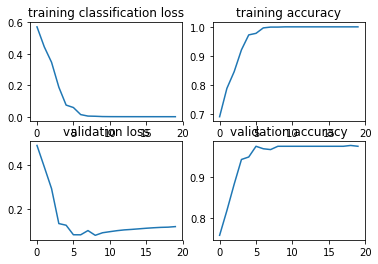

In [23]:
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)

In [24]:
from synthetic_dataloader import *

In [25]:
shape_gender_train = ShapeGenderDataset(train_df)
shape_gender_val = ShapeGenderDataset(val_df)
shape_gender_test = ShapeGenderDataset(test_df)

In [26]:
reps = []
shapes = []
colors= []
encoder.eval()
with torch.no_grad():
    for i in range(len(train_df)):
        img, shape, color = shape_gender_train[i]
        img = img.to(device).float()
        img.unsqueeze_(0)
        encoding = encoder(img)
        reps.append(encoding[0].cpu().numpy())
        shapes.append(shape)
        colors.append(color)
        if i == 0: 
            print(i)

0


In [27]:
y_num = pd.DataFrame(shapes)
s = pd.DataFrame(colors)
X = pd.DataFrame(reps)

In [28]:
import matplotlib.cm as cm
plt.style.use('bmh')

In [29]:
colors = cm.Dark2(np.linspace(0, 1, len(train_df.classes)))

In [30]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [31]:
X_pca = PCA(n_components=50).fit_transform(X, X)
tsne = TSNE(n_components=2, init='random', random_state=0)
# X_r = tsne.fit_transform(X)
X_r = tsne.fit_transform(X_pca)

In [32]:
train_df.class_to_idx

{'circle': 0, 'rectangle': 1}

Saved to: indep_tsne_train_classifier_y.pdf


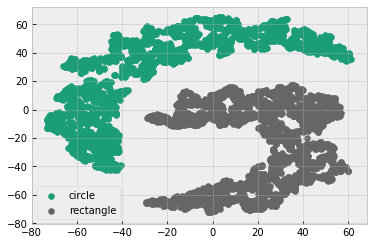

In [33]:
plt.scatter(X_r[(y_num == 0)[0], 0], X_r[(y_num == 0)[0], 1], c=colors[0], label='circle')
plt.scatter(X_r[(y_num == 1)[0], 0], X_r[(y_num == 1)[0], 1], c=colors[1], label='rectangle')
plt.legend()
# plt.show()
out = "indep_tsne_train_classifier_y.pdf"
plt.savefig(out)
print("Saved to: {}".format(out))

Saved to: indep_tsne_train_classifier_s.pdf


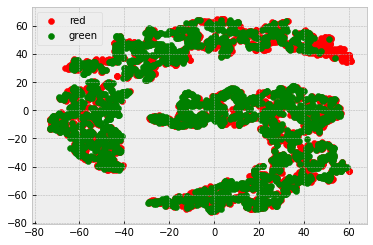

In [34]:
plt.figure()
plt.scatter(X_r[(s == 1)[0], 0], X_r[(s == 1)[0], 1], c='red', label='red')
plt.scatter(X_r[(s == 0)[0], 0], X_r[(s == 0)[0], 1], c='green', label='green')
plt.legend()
out = "indep_tsne_train_classifier_s.pdf"
plt.savefig(out)
print("Saved to: {}".format(out))
# plt.show()

In [35]:
reps = []
shapes = []
colors= []
encoder.eval()
with torch.no_grad():
    for i in range(len(test_df)):
        img, shape, color = shape_gender_test[i]
        img = img.to(device).float()
        img.unsqueeze_(0)
        encoding = encoder(img)
        reps.append(encoding[0].cpu().numpy())
        shapes.append(shape)
        colors.append(color)
        if i == 0: 
            print(i)

0


In [36]:
y_num = pd.DataFrame(shapes)
s = pd.DataFrame(colors)
X = pd.DataFrame(reps)

In [37]:
X_pca = PCA(n_components=50).fit_transform(X, X)
tsne = TSNE(n_components=2, init='random', random_state=0)
# X_r = tsne.fit_transform(X)
X_r = tsne.fit_transform(X_pca)

In [38]:
colors = cm.Dark2(np.linspace(0, 1, len(train_df.classes)))

Saved to: indep_tsne_test_classifier_y.pdf


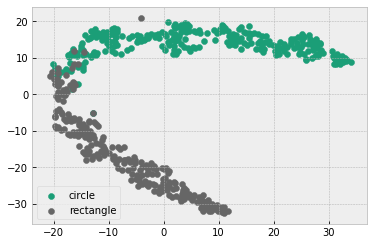

In [39]:
plt.scatter(X_r[(y_num == 0)[0], 0], X_r[(y_num == 0)[0], 1], c=colors[0], label='circle')
plt.scatter(X_r[(y_num == 1)[0], 0], X_r[(y_num == 1)[0], 1], c=colors[1], label='rectangle')
plt.legend()
out = "indep_tsne_test_classifier_y.pdf"
plt.savefig(out)
print("Saved to: {}".format(out))

Saved to: indep_tsne_test_classifier_s.pdf


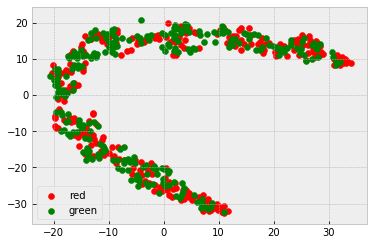

In [40]:
plt.figure()
plt.scatter(X_r[(s == 1)[0], 0], X_r[(s == 1)[0], 1], c='red', label='red')
plt.scatter(X_r[(s == 0)[0], 0], X_r[(s == 0)[0], 1], c='green', label='green')
plt.legend()
out = "indep_tsne_test_classifier_s.pdf"
plt.savefig(out)
print("Saved to: {}".format(out))